# Movie Recommender Case Study

Today you are going to have a little friendly competition with your classmates.

You are going to building a recommendation system based off data from the
[MovieLens dataset](http://grouplens.org/datasets/movielens/). It includes movie
information, user information, and the users' ratings. Your goal is to build a
recommendation system and to suggest movies to users!

The **movies data** and **user data** are in `data/movies.dat` and `data/users.dat`.

The **ratings data** can be found in `data/training.csv`. The users' ratings have been broken into a training and test set for you (to obtain the testing set, we have split the 20% of **the most recent** ratings).

In [249]:
import pandas as pd
import numpy as np
import json

In [250]:
ratings_df = pd.read_csv('data/training.csv')
ratings_df = ratings_df.drop(columns = 'timestamp')

In [251]:
ratings_df.describe()

,user,movie,rating
count,800000.000000,800000.000000,800000.000000
mean,3403.097837,1849.257256,3.590479
std,1546.589028,1086.852485,1.120376
min,636.000000,1.000000,1.000000
25%,2035.000000,1028.000000,3.000000
50%,3507.000000,1788.000000,4.000000
75%,4695.000000,2750.000000,4.000000
max,6040.000000,3952.000000,5.000000


# Apply ratings table filters.
- This will help to reduce the sparseness and may allow us to get better predictions from the ALS.


## *Thumbs up* filter
- Delete movies that almost no one has rated highly.
- 3662 total movies in training data. 
- Drop 1319 duds (i.e. 99.7% of ratings < 4.7). 
- Yields 2204 movies.

In [252]:
# Group movies by rating and get their mean and std ratings. Alternatively, we could count the number of 5's. Drop if less than 5%.
movie = ratings_df.groupby('movie').agg(mean = ('rating', 'mean'), std= ('rating','std'))
movie.head(2)

,mean,std
movie,,
1,4.145226,0.858766
2,3.197880,0.979288


In [253]:
# 99.7% of ratings below 4.7
movie['stat_score'] = movie['mean'] + 1.5 * movie['std']
movie[movie['stat_score'] < 4.7].count()

mean          1319
std           1319
stat_score    1319
dtype: int64

In [254]:
thumbs_up = movie[movie['stat_score'] >= 4.7]
thumbs_up = thumbs_up.drop(columns=['std','mean'])
thumbs_up.count()

stat_score    2204
dtype: int64

In [255]:
thumbs_up.head(2)

,stat_score
movie,
1,5.433374
6,5.264844


In [256]:
# Apply 'thumbs up' filter to ratings data table
thumbs_up_ratings = ratings_df.merge(thumbs_up, how='inner', left_on='movie', right_on='movie')

In [257]:
thumbs_up_ratings.head(2)

,user,movie,rating,stat_score
0,6040,858,4,5.712651
1,6037,858,5,5.712651


## *Too few ratings* filter
- Trim movies if less than 15 ratings
- Drop 266 low review counts. 
- Yields 1938 movies.

In [258]:
low_count_ratings = thumbs_up_ratings.groupby('movie').count()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f654e111250>]],
      dtype=object)

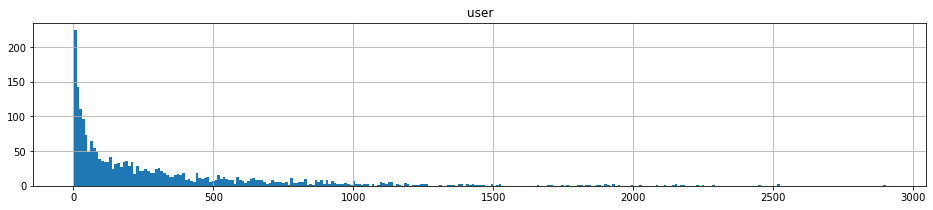

In [259]:
low_count_ratings.hist('user', bins=300, figsize=(16,3))

In [260]:
low_count_ratings[low_count_ratings['user'] < 15].count()

user          266
rating        266
stat_score    266
dtype: int64

In [261]:
good_count_ratings = low_count_ratings[low_count_ratings['user']>= 15].reset_index()

In [262]:
good_count_ratings = good_count_ratings.drop(['user', 'rating', 'stat_score'], axis = 1)

In [263]:
good_count_ratings.count()

movie    1938
dtype: int64

In [264]:
two_filter_ratings = thumbs_up_ratings.merge(good_count_ratings, how='inner', left_on='movie', right_on='movie')

In [265]:
two_filter_ratings.head()

,user,movie,rating,stat_score
0,6040,858,4,5.712651
1,6037,858,5,5.712651
2,6033,858,4,5.712651
3,6028,858,4,5.712651
4,6026,858,4,5.712651


In [266]:
two_filter_ratings.count()

user          642509
movie         642509
rating        642509
stat_score    642509
dtype: int64

In [267]:
two_filter_ratings.to_csv('data/two_filter_ratings.csv')

# Working on metadata

In [110]:
movies_df = pd.read_csv('data/movies.txt', sep = '::', names=['id', 'title', 'year', 'genre'])

/home/salvir1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [30]:
movies_df.head()

,id,title,year,genre
0,1,Toy Story,1995,Animation|Children's|Comedy
1,2,Jumanji,1995,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,1995,Comedy|Romance
3,4,Waiting to Exhale,1995,Comedy|Drama
4,5,Father of the Bride Part II,1995,Comedy


In [31]:
users_df = pd.read_csv('data/users.txt', sep = '::', names=['id', 'sex', 'age', 'occ', 'zip'])

/home/salvir1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [36]:
users_df.head(20)

,id,sex,age,occ,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


In [73]:
users_df.to_csv('data/formatted_users.csv')

In [40]:
movie_meta = pd.read_csv('data/movies_metadata.csv')

/home/salvir1/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
movie_meta.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [70]:
mv_master = movies_df.merge(movie_meta, how='left', left_on = 'title', right_on='title')

In [71]:
mv_master.drop(['spoken_languages','tagline','video','production_countries', 'release_date', 'homepage', 'status', 'original_title', 'imdb_id', 'poster_path', 'production_companies', 'budget', 'belongs_to_collection', 'adult'], axis=1, inplace=True)

In [72]:
mv_master.to_csv('data/mv_master.csv')

You can get **additional metadata** by downloading [The Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/version/7). This may be useful for creating NLP (content-based) features, which could be part of your team's solution to the "cold start" problem. (Remember to start with a simple model first!)

## Your mission [read carefully]

You are provided a **request** file in `data/requests.csv`. It contains a list of `user,movie` pairs.

**Your mission** is to provide a rating for each of those `user,movie` pairs. You will submit a csv file with three columns `user,movie,rating` as created by the script `src/run.py` (see below).

We ask you to **provide this submission file via a link to your github repository** (the master of your group).

Your **score** will be measured based on how well you predict the ratings for the users' ratings compared to our test set. At the end of the day, we will collect your predicted ratings and provide a score (see below).


## How to implement your recommender

The file `src/recommender.py` is your main template for creating your recommender. You can work from this file and implement whatever strategy you think is best. You need to implement both the `.fit()` and the `.transform()` methods.

**Tips**: You might want to consider working in a notebook first, in order to establish a proper training strategy (proof of concept). In practice, it is not necessary to implement the file `src/recommender.py` to provide a submission file (a notebook can perfectly do that without running through `src/run.py`). If you don't do that during the case study, eventually we recommend you to try to integrate your implementation into the `src/recommender.py` file.


## How to run your recommender

`src/run.py` has been prepared for your convenience (doesn't need modification). By executing it you create an instance of a `MovieRecommender` class (see file `src/recommender.py`), feeds it with the training data and outputs the results in a file.

It outputs a _properly formatted_ file of recommendations for you!

  Here's how to use this script:
  ```bash
  usage: run.py [-h] [--train TRAIN] [--requests REQUESTS] [--silent] outputfile

  positional arguments:
    outputfile           output file (where predictions are stored)

  optional arguments:
    -h, --help           show this help message and exit
    --train TRAIN        path to training ratings file (to fit)
    --requests REQUESTS  path to the input requests (to predict)
    --silent             deactivate debug output
  ```

When running this script, **you need to** specify your prediction output file as an argument (the one you will submit).

**Try now** to create a random prediction file by typing:

In [1]:
bash python src/run.py data/sample_submission.csv

SyntaxError: invalid syntax (<ipython-input-1-71149be68475>, line 1)

## How we will submit your prediction for scoring

`src/submit.py` is the script **we** will use to submit your results for scoring. It reads your submission from a csv as produced by `src/run.py` compares it to our **secret testing set**.

Here's how we use this script:
  ```bash
  usage: submit.py [-h] [--silent] [--testing TESTING] predfile

  positional arguments:
    predfile           prediction file to submit

  optional arguments:
    -h, --help         show this help message and exit
    --silent           deactivate debug output
    --testing TESTING  testing set
  ```

**You need to** specify your prediction file (the one produced by `src/run.py`) as an argument.

If you want to try this script, try running :

```bash
python src/submit.py --testing data/fake_testing.csv data/sample_submission.csv
```

It should return a score around 2.50. **WARNING: this fake_testing.csv is just a random testing test, DO NOT USE IT to validate your model**.


## Evaluation: how the score is computed

We provide this submit script so that you can understand the scoring methodology. Look at the function `compute_score()` to get the idea:
- we will use your prediction file to extract, for each user, the 5% most highly predicted movies
- we will look at the actual rating of those movies in our hidden testing set.
- we will compute the mean of those ratings.

Thus, for an algorithm to score well, it only needs to identify which movies a user is likely to rate most highly (so the absolute accuracy of your ratings is less important than the rank ordering).

As mentioned above, your submission should be in the same format as the sample
submission file, and the only thing that will be changed is the ratings column.


## Note on running your script with Spark

If your `recommender.py` script relies on spark, you may want to use the script `run_on_spark.sh` to execute your code.

In a terminal, use: `run_on_spark.sh src/run.py` with arguments to run your recommender.

The `src/submit.py` doesn't need to run on spark, as it simply reads the result file produced by `run.py`.